# Project for the course: Computational Mathematics
## Group 1: Fois Giulia, Manini Nicolas

 ### Parsing of the execution data of the algorithm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Read the summary csv, and the csv containing the execution logs for each task

In [2]:
Percentages = [10,30,60]
def getFolderName(perc):
    return 'Preliminary_Sparse_' + str(perc)

SummaryFile = 'summary.csv'
LogsFolder = 'logs'

In [3]:
dfSum = {}
for perc in Percentages:
    folderName = getFolderName(perc)
    summary_path = "{}/{}".format(folderName, SummaryFile)
    dfTmp = pd.read_csv(summary_path)
    dfTmp['density'] = perc
    
    dfTmp['Batch'] = dfTmp['InputName'].str.split('_').str[1]
    dfTmp['BatchIndex'] = dfTmp['InputName'].str.split('_').str[2]
    dfTmp['KIndex'] = dfTmp['InputName'].str.split('_').str[3]

    dfTmp['Batch'] = dfTmp['Batch'].astype(int)
    dfTmp['BatchIndex'] = dfTmp['BatchIndex'].astype(int)
    dfTmp['KIndex'] = dfTmp['KIndex'].astype(int)

    dfTmp['TimeIter'] = dfTmp['Our_time'].div(dfTmp['Our_Iter'])
    dfTmp['TimeDelta_1Iter'] = dfTmp['Svd_time'] - dfTmp['TimeIter']
    dfTmp['ConvenientIters'] = np.floor(dfTmp['Svd_time'] .div(dfTmp['TimeIter']))

    dfSum[perc] = dfTmp
    
dfSumAll = pd.concat([dfSum[x] for x in Percentages])

In [4]:
import os
dfLogs = {}
for perc in Percentages:
    folderName = getFolderName(perc)
    logs_path = "{}/{}".format(folderName, LogsFolder)
    for filename in filter(lambda x:x.endswith(".csv"), os.listdir(logs_path)):
        dfTemp = pd.read_csv("{}/{}".format(logs_path, filename))
        dfTemp['ErrorRatio'] = (abs(dfTemp['Error'] - dfTemp['Error'].shift(1))).div(dfTemp['Error'].shift(1))
        
        spl = filename.split('_')
        batch = int(spl[2])
        bidx = int(spl[3])
        kidx = int(spl[4][:-4])
        dfLogs[(perc, batch, bidx, kidx)] = dfTemp  

In [5]:
dfGroupLast = {}

# We consider only rk(A)-1 approximation
for perc in Percentages:
    dfTmp = dfSum[perc]
    dfFilt = dfTmp[dfTmp['InputRk'] == (dfTmp['TargetRk'] + 1)][['density', 'InputM', 'InputRk', 'TargetRk', 'Delta_diff']]
    dfGrouped = dfFilt.groupby('InputM').mean()
    dfGroupLast[perc] = dfGrouped

In [6]:
dfGroupLast[60]

,density,InputRk,TargetRk,Delta_diff
InputM,,,,
10,60,10,9,5.138120e-10
20,60,20,19,5.418578e-11
40,60,40,39,1.090192e-11
80,60,80,79,5.978571e-11
160,60,160,159,6.353945e-11
320,60,320,319,1.925387e-11


### Preliminary plots

In [8]:
def getColor(perc):
    if perc == 10:
        clr = 'red'
    if perc == 30:
        clr = 'blue'
    if perc == 60:
        clr = 'green'
    return clr

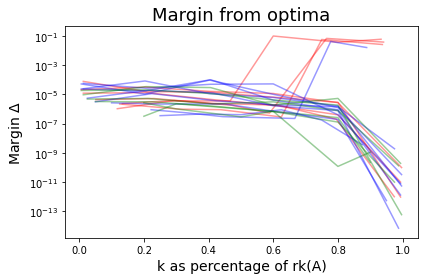

In [10]:
import random as rnd
rnd.seed(12)

plt.yscale('log')

for perc in Percentages:
    dfTmp = dfSum[perc]
    Batches = (dfTmp['Batch'].unique())
    for b in Batches:
        bidxs = dfTmp[dfTmp['Batch'] == b]['BatchIndex'].unique()
        kidxs = dfTmp[(dfTmp['Batch'] == b) & (dfTmp['BatchIndex'] == bidxs[0])]['KIndex'].unique()
        nks = len(kidxs)
        for bidx in bidxs:
            ks = dfTmp[(dfTmp['Batch'] == b) & (dfTmp['BatchIndex'] == bidx)]['TargetRk']

            origRank = dfTmp[(dfTmp['Batch'] == b) & (dfTmp['BatchIndex'] == bidx)]['InputRk'].iloc[0]
            xax = ks/origRank

            matrixM = dfTmp[(dfTmp['Batch'] == b) & (dfTmp['BatchIndex'] == bidx)]['InputM'].iloc[0]
            matrixN = dfTmp[(dfTmp['Batch'] == b) & (dfTmp['BatchIndex'] == bidx)]['InputN'].iloc[0]

            yax = dfTmp[(dfTmp['Batch'] == b) & (dfTmp['BatchIndex'] == bidx)]['Delta_diff']


            if (rnd.random() < 0.40): 
                plt.plot(xax, yax, color=getColor(perc), alpha=0.4)
            
            
plt.title("Margin from optima", fontsize=18)
plt.xlabel("k as percentage of rk(A)", fontsize=14)
plt.ylabel(r'Margin $\Delta$', fontsize=14)
plt.tight_layout()
plt.savefig('confronto_margin_sparse.png', format='png', dpi=300)
plt.show()

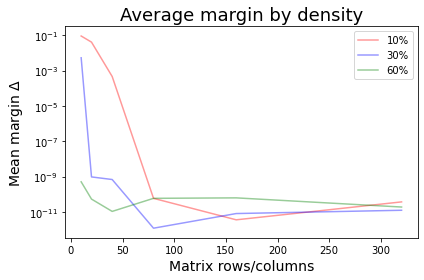

In [22]:
plt.yscale('log')
for perc in Percentages:
    dfTmp = dfGroupLast[perc]
    xax = list(dfTmp.index)
    yax = dfTmp['Delta_diff']
    plt.plot(xax, yax, color=getColor(perc), alpha=0.4, label="{}%".format(perc))

plt.legend(loc="best")

plt.title("Average margin by density", fontsize=18)
plt.xlabel("Matrix rows/columns", fontsize=14)
plt.ylabel(r'Mean margin $\Delta$', fontsize=14)
plt.tight_layout()
plt.savefig('confronto_margin_size_sparse.png', format='png', dpi=300)
plt.show()

In [15]:
list(dfTmp.index)

[10, 20, 40, 80, 160, 320]